# Install Environment using

```conda env create -f pipeline_env.yml```

```conda activate dphpc```

In [397]:
import os
import typing
import re
from glob import glob
import numpy as np  # <--
import datetime
from tqdm.notebook import tqdm # <--
import matplotlib.pyplot as plt # <--
import matplotlib.ticker as mticker

In [398]:
import pandas as pd # <--
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 220)

In [399]:
import seaborn as sns # <--
sns.set_style("darkgrid")
sns.set_context("poster")

In [400]:
def load_usage_info(logfile):
    if not logfile:
      return

    usage_info_starts_at = 0

    with open(logfile, 'r') as handle:
        for linenumber, line in enumerate(handle, 0):
            if "Resource usage summary" in line:
                usage_info_starts_at = linenumber
                break 
            if linenumber > 35:
                return

    usage_info = pd.read_csv(logfile, sep="\s+:\s+", skiprows=usage_info_starts_at+2, nrows=10, header=None, skipinitialspace=True).transpose()
    usage_info = usage_info.rename(columns=usage_info.iloc[0]).drop(0).reset_index(drop=True)
    usage_info["logfile"] = logfile
    
    return usage_info

In [401]:
def load_cpu_info(cpufile):
    if not cpufile:
      return

    cpu_info = pd.read_csv(cpufile, sep=":\s+", header=None).transpose()
    cpu_info = cpu_info.rename(columns=cpu_info.iloc[0]).drop(0).reset_index(drop=True)
    cpu_info["cpufile"] = cpufile

    return cpu_info

In [402]:
def load_lsb_data(datafile):
   if not datafile:
      return
   
   lsb_data = pd.read_csv(datafile, comment='#', sep='\s+')
   lsb_data["datafile"] = datafile
   return lsb_data

In [403]:
def load_cg_data(datafile):
    if not datafile:
      return

    kernel_info_starts_at = -1
    with open(datafile, 'r') as handle:
        for linenumber, line in enumerate(handle, 0):
            if "fn=kernel_" in line:
                kernel_info_starts_at = linenumber
                break 

    if kernel_info_starts_at < 0:
      return
    
    chache_data = pd.read_csv(datafile, skiprows=kernel_info_starts_at+1, sep="\s+", nrows=1, index_col=None, header=None, skipinitialspace=True, names=["unknown", "Ir", "I1mr", "ILmr", "Dr", "D1mr", "DLmr", "Dw", "D1mw", "DLmw"])
    chache_data["datafile"] = datafile
    return chache_data
    

In [404]:

# print(load_cg_data("./2021-11-23_20-04-51-cholesky_mpi_ll_naive/P4-D11/cachegrind.out.13960"))

# Ir    I1mr        ILmr    Dr  D1mr        DLmr        Dw      D1mw        DLmw 
# 0     2192211505  29      25  724913090   47623304    397786  365606246   1655786 616107


In [405]:
def load_experiment(datafile: str) -> typing.Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    experiment_path = os.path.dirname(datafile)

    cpufile = glob(experiment_path+"/CPU*")
    logfile = glob(experiment_path+"/job*")
    #errorfile = glob(experiment_path+"/error*")

    if not cpufile or not logfile:
        return

    cpufile = cpufile[0]
    logfile = logfile[0]

    experiment_date = experiment_path[2:21]
    experiment_binary, experiment_params = experiment_path[22:].split("/")
    experiment_processes, experiment_dim = experiment_params.split("-")
    
    experiment = pd.DataFrame({
        "date" : datetime.datetime.strptime(experiment_date, '%Y-%m-%d_%H-%M-%S'),
        "binary" : experiment_binary,
        "p" : int(experiment_processes[1:]), 
        "d" : int(experiment_dim[1:]),
        #"m" : int(experiment_dim[1:]), #TODO: Update pipeline to use m x n matrix
        #"n" : int(experiment_dim[1:]), #TODO: Update pipeline to use m x n matrix
        "datafile" : datafile,
        "cpufile" : cpufile,
        "logfile" : logfile, 
        #"errorfile" : errorfile,
    }, index=[0])
   
    return experiment


In [406]:
# Collect data from all experiments

experiments=pd.DataFrame()
libscibenchdata=pd.DataFrame()
cachegrinddata=pd.DataFrame()
usage_info=pd.DataFrame()
cpu_info=pd.DataFrame()

print("Load libscibench data")
for libscibench in tqdm(glob("./2021*/P*D*/lsb*"), unit='Files'):
    experiment = load_experiment(libscibench)
    if experiment is None:
        continue

    experiments = experiments.append(experiment)
    libscibenchdata = libscibenchdata.append(load_lsb_data(experiment["datafile"][0]))

libscibenchdata = libscibenchdata.reset_index(drop=True)

print("\nLoad cachegrind data")
for cachegrind in tqdm(glob("./2021*/P*D*/cachegrind*"), unit='Files'):
    experiment = load_experiment(cachegrind)
    if experiment is None:
        continue
    
    experiments = experiments.append(experiment)
    cachegrinddata = cachegrinddata.append(load_cg_data(experiment["datafile"][0]))

cachegrinddata = cachegrinddata.reset_index(drop=True)


experiments = experiments.reset_index(drop=True)

print("\nLoad usage data")
usage_info = usage_info.append([load_usage_info(logfile) for logfile in tqdm(experiments["logfile"].unique(), unit='Files')])
usage_info = usage_info.drop_duplicates().reset_index(drop=True)

print("\nLoad cpu data")
cpu_info = cpu_info.append([load_cpu_info(cpufile) for cpufile in tqdm(experiments["cpufile"].unique(), unit='Files')])
cpu_info = cpu_info.drop_duplicates().reset_index(drop=True)

Load libscibench data


  0%|          | 0/1576 [00:00<?, ?Files/s]

KeyboardInterrupt: 

In [ ]:
print("Experiments:")
print(experiments.head(2))
print("\nlibscibenchdata:")
print(libscibenchdata.head(2))
print("\cachegrinddata:")
print(cachegrinddata.head(2))
print("\nUsage_info:")
print(usage_info.head(2))
print("\nCpu_info:")
print(cpu_info.head(2))


Experiments:
                 date                     binary  p  d                       datafile                        cpufile                        logfile
0 2021-11-24 10:17:37  cholesky_mpi_ll_optimised  2  5  ./2021-11-24_10-17-37-chol...  ./2021-11-24_10-17-37-chol...  ./2021-11-24_10-17-37-chol...
1 2021-11-24 10:17:37  cholesky_mpi_ll_optimised  2  5  ./2021-11-24_10-17-37-chol...  ./2021-11-24_10-17-37-chol...  ./2021-11-24_10-17-37-chol...

libscibenchdata:
   rank  size type  id         time  overhead                       datafile region
0   2.0   128  MPI   0  1220.802734         1  ./2021-11-24_10-18-01-chol...    NaN
1   2.0   128  MPI   1  1598.404297         3  ./2021-11-24_10-18-01-chol...    NaN
\cachegrinddata:
   unknown     Ir  I1mr  ILmr     Dr  D1mr  DLmr    Dw  D1mw  DLmw                       datafile
0        0  69026    13    12  11434     3     0  1468     0     0  ./2021-11-23_19-59-19-chol...
1        0  69026    14    12  11434     3     0  1468     0

/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


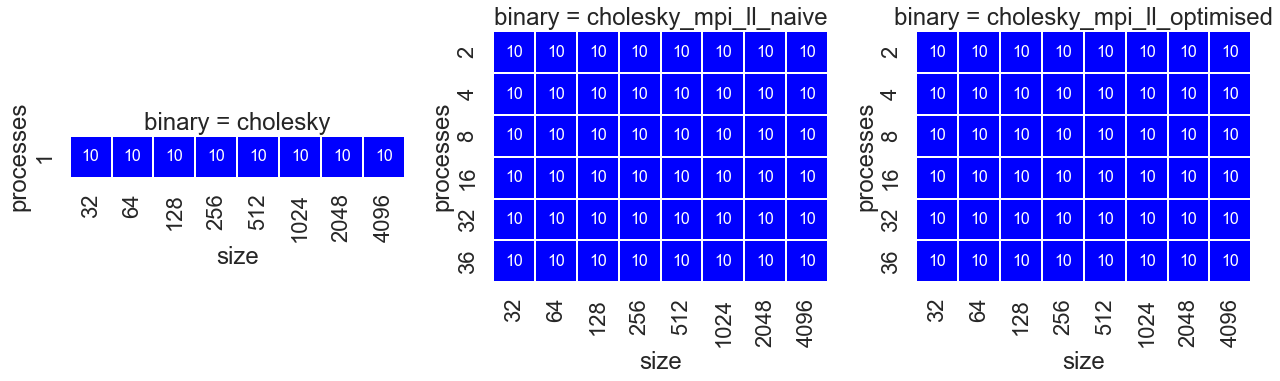

In [ ]:
# Data Coverage

data = pd.merge(experiments, libscibenchdata[["datafile", "id", "rank", "size", "time"]], on="datafile")
data = pd.merge(data, cpu_info[["cpufile", "CPU max MHz"]], on="cpufile")
data = data[["binary", "date", "p", "size", "id", "rank", "time", "CPU max MHz"]]
data = data.groupby(["binary", "date", "p", "size", "id", "CPU max MHz"], as_index=False)["time"].max().reset_index(drop=True)
data = data.groupby(["binary", "date", "p", "size", "CPU max MHz"], as_index=False)["time"].count()

def facet(data, color):
    coverage = data.pivot(index="p", columns='size', values='time')
    f = sns.heatmap(coverage, cmap='winter', annot=True, cbar=False, square=True, linewidth=2, linecolor='w', annot_kws={'fontsize':16})
    f.set_ylabel("processes")
   

g = sns.FacetGrid(data, col="binary", size=6, legend_out=True, sharex=False, sharey=False)
yticks = np.sort(data["p"].unique())
xticks = np.sort(data["size"].unique())

g = g.map_dataframe(facet)

g.figure.savefig("./plots/data_coverage.png")


In [ ]:
# Performance Plot

data = pd.merge(experiments, libscibenchdata[["datafile", "id", "rank", "size", "time"]], on="datafile")
data = pd.merge(data, cpu_info[["cpufile", "CPU max MHz"]], on="cpufile")
data = data[["binary", "p", "size", "id", "rank", "time", "CPU max MHz"]]

data = data.groupby(["binary", "size", "p", "id", "CPU max MHz"], as_index=False)["time"].max().reset_index(drop=True)

print(data.head())

     binary  size  p  id CPU max MHz       time
0  cholesky    32  1   0   2701.0000  10.077148
1  cholesky    32  1   1   2701.0000  13.525391
2  cholesky    32  1   2   2701.0000   4.986328
3  cholesky    32  1   3   2701.0000   4.941406
4  cholesky    32  1   4   2701.0000   4.864258


/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


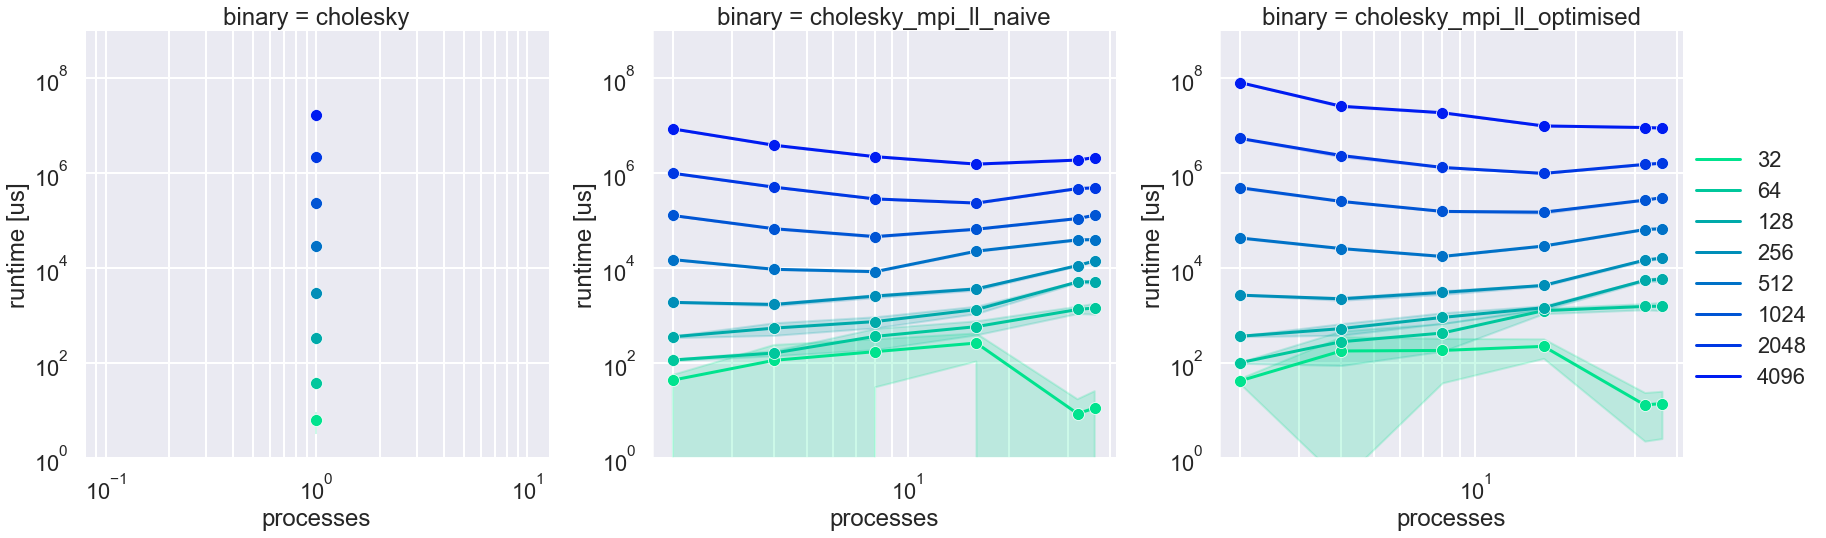

In [ ]:
# Runtime per process

data = data.sort_values(by=["size"])

def facet(data, color):
    n_colors = len(data["size"].unique())

    f = sns.lineplot(data=data, x="p", y="time", hue="size", ci='sd', marker='o', palette=sns.color_palette('winter_r', n_colors))
    f.set(xscale="log", yscale="log")
    f.set_xlabel("processes")
    f.set_ylabel("runtime [us]")
    f.set(ylim=(10**0, 10**9)) 

    plt.grid(True,which="both")

    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    f.get_xaxis().set_minor_locator(locmin)

g = sns.FacetGrid(data, col="binary", size=8, sharex=False, sharey=False)
g = g.map_dataframe(facet)
g.add_legend()

g.figure.savefig("./plots/runtime_per_size.png")

/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


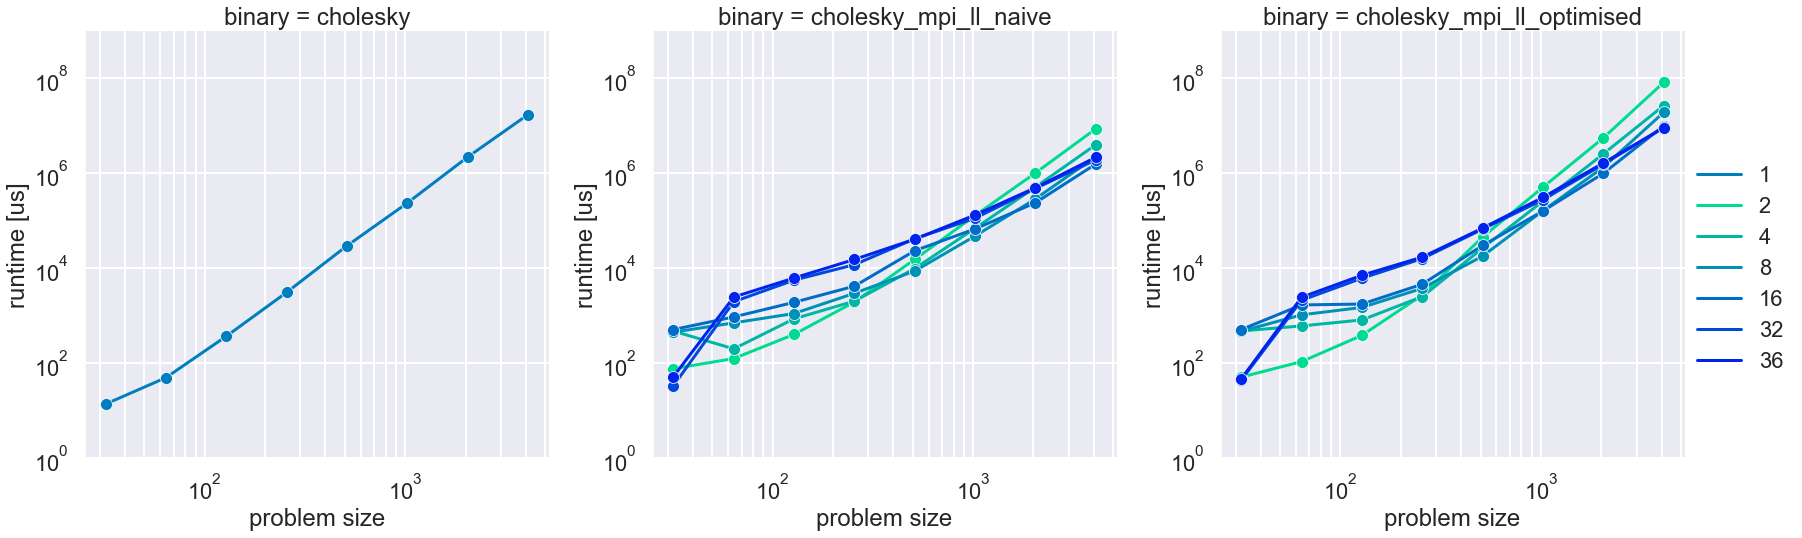

In [ ]:
# Runtime as a function of problem size

data = data.sort_values(by=["p"])

def facet(data, color):
    n_colors = len(data["p"].unique())

    f = sns.lineplot(data=data, x="size", y="time", hue="p", ci='sd', marker='o', palette=sns.color_palette('winter_r', n_colors))
    f.set(xscale="log", yscale="log")
    f.set_xlabel("problem size")
    f.set_ylabel("runtime [us]")
    f.set(ylim=(10**0, 10**9)) 

    plt.grid(True,which="both")

    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    f.get_xaxis().set_minor_locator(locmin)

g = sns.FacetGrid(data, col="binary", size=8, sharex=False, sharey=False)
g = g.map_dataframe(facet)
g.add_legend()

g.figure.savefig("./plots/runtime_per_process.png")


In [ ]:
## Speed up

data = pd.merge(experiments, libscibenchdata[["datafile", "id", "rank", "size", "time"]], on="datafile")
data = data[["binary", "p", "size", "id", "rank", "time"]]

data = data.groupby(["binary", "size", "p"], as_index=False)["time"].max()
#data["cycles"] = data["time"] * data["CPU max MHz"].astype('float')

baseline = data["binary"].isin(["cholesky"])
sequential = data[baseline]
parallel = data[~baseline & data["size"].isin(sequential["size"])]
result = pd.merge(parallel, sequential[["size", "time"]], on="size", suffixes=["_par", "_seq"])
result["speedup"] = result["time_seq"] / result["time_par"]

print(result.head())


                  binary  size   p    time_par   time_seq   speedup
0  cholesky_mpi_ll_naive    32   2   75.551758  13.525391  0.179022
1  cholesky_mpi_ll_naive    32   4  466.672852  13.525391  0.028983
2  cholesky_mpi_ll_naive    32   8  443.230469  13.525391  0.030515
3  cholesky_mpi_ll_naive    32  16  503.091797  13.525391  0.026885
4  cholesky_mpi_ll_naive    32  32   32.928711  13.525391  0.410748


/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


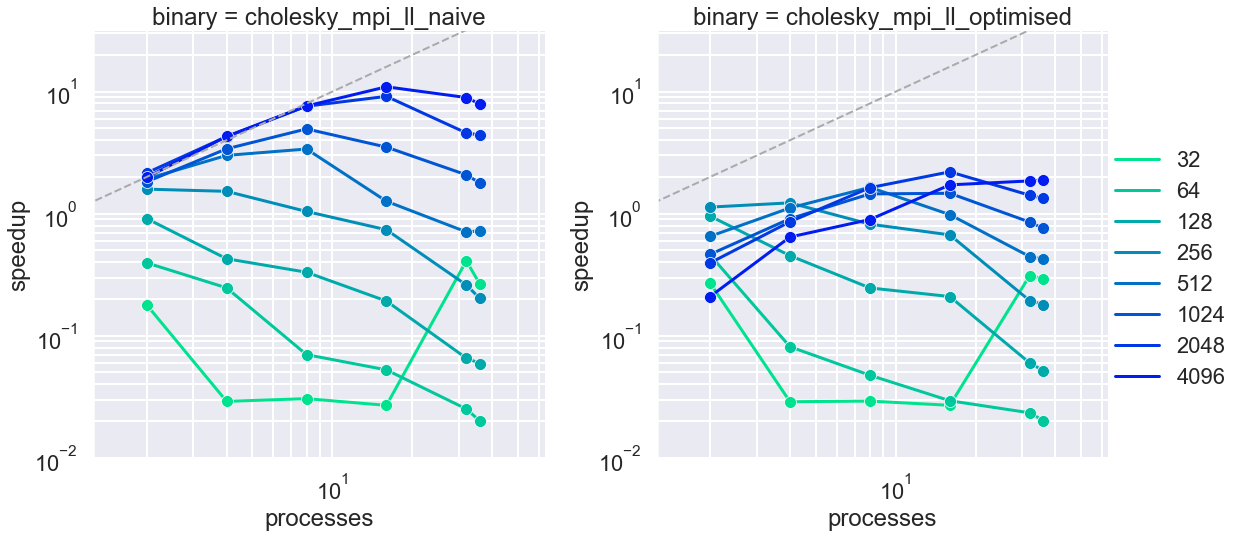

In [ ]:
def facet(data, color):
      
    n_colors = len(data["size"].unique())

    f = sns.lineplot(data=data, x="p", y="speedup", hue="size", ci='sd', marker='o', palette=sns.color_palette('winter_r', n_colors))
    f.set(xscale="log", yscale="log")
    f.set_xlabel("processes")
    f.set_ylabel("speedup")
    f.set(ylim=(10**-2, 10**1.5)) 
    f.set(xlim=(10**0.1, 10**1.8)) 

    X_plot = np.logspace(-1, 2, 2)
    plt.grid(True,which="both")
    plt.plot(X_plot, X_plot, linewidth=2, color='#AAAAAA', linestyle='--')

    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    f.get_xaxis().set_minor_locator(locmin)

g = sns.FacetGrid(result, col="binary", size=8, sharex=False, sharey=False)
g = g.map_dataframe(facet)
g.add_legend()

g.figure.savefig("./plots/speedup_per_process.png")


/Users/haeflisi/opt/anaconda3/envs/dphpc/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


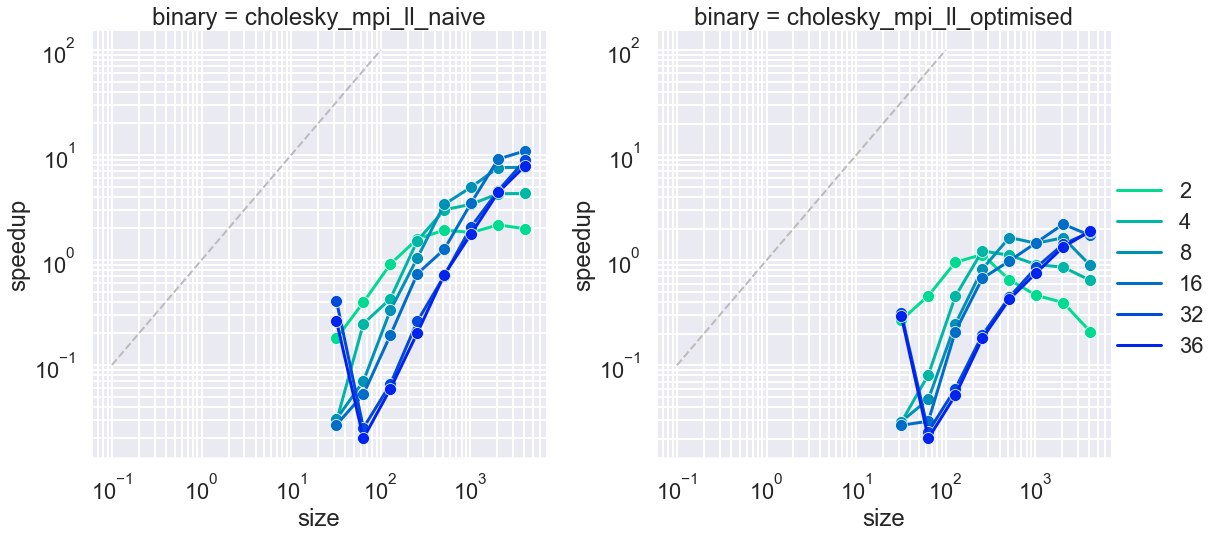

In [ ]:
def facet(data, color):
      
    n_colors = len(data["p"].unique())

    f = sns.lineplot(data=data, x="size", y="speedup", hue="p", ci='sd', marker='o', palette=sns.color_palette('winter_r', n_colors))
    f.set(xscale="log", yscale="log")
    f.set_xlabel("problem size")
    f.set_ylabel("speedup")
    #f.set(ylim=(10**-2, 10**1.5)) 
    #f.set(xlim=(10**0.1, 10**1.8)) 

    X_plot = np.logspace(-1, 2, 2)
    plt.grid(True,which="both")
    plt.plot(X_plot, X_plot, linewidth=2, color='#BBBBBB', linestyle='--')

    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    f.get_xaxis().set_minor_locator(locmin)

g = sns.FacetGrid(result, col="binary", size=8, sharex=False, sharey=False)
g = g.map_dataframe(facet)
g.add_legend()

g.figure.savefig("./plots/speedup_per_size.png")
